In [1]:
import rfnetwork as rfn
from pathlib import Path
import numpy as np

DATA_DIR = Path.cwd() / 'data'

line50 = rfn.elements.Line(z0=50)
line70p7 = rfn.elements.Line(z0=70.7)

f0 = 3e9
lam0 = rfn.const.c0_in / f0
frequency = np.arange(0.6, 6, 0.01) * 1e9

lna = rfn.Component_SnP(file=DATA_DIR / "QPL9503_5V_with_NP.s2p")

## Multi-Port Noise Wave Analysis

This notebook tests the multi-port noise wave code on a few simple cases and compares the results with ADS.

In [2]:
class splitter(rfn.Network):
    """
    Non-isolated splitter.
    """
    p1 = line50(e_len=20, fc=f0)
    p2 = line70p7(lam0/4)
    p3 = line70p7(lam0/4)

    nodes = [
        (p1|2, p2|1, p3|1),
        (p3|2, "P3"),
        (p2|2, "P2"),
        (p1|1, "P1"),
    ]

class wilk(rfn.Network):
    """
    Isolated wilkison combiner/splitter
    """
    p1 = line50(e_len=20, fc=f0)
    p2 = line70p7(lam0/4)
    p3 = line70p7(lam0/4)
    r1 = rfn.elements.Resistor(100)

    nodes = [
        (p1|2, p2|1, p3|1),
        (p2|2, r1|1, "P2"),
        (p3|2, r1|2, "P3"),
        (p1|1, "P1"),
    ]

## Single Amp

![image](data/img/ads_sch.png)

Text(0.5, 1.0, 'QPL9503 NF')

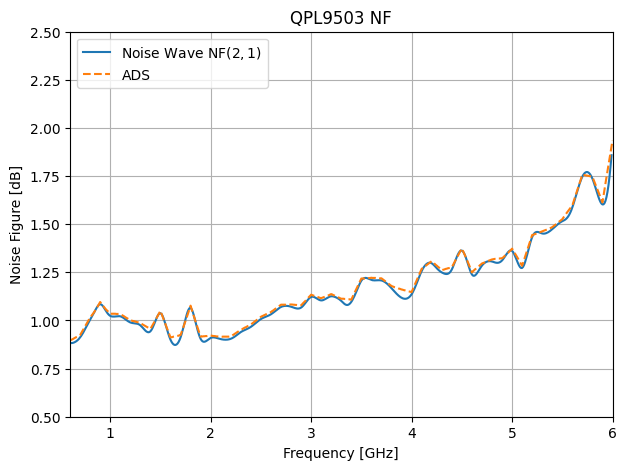

In [3]:
class single_amp(rfn.Network):
    u1 = lna
    att = rfn.elements.Attenuator(0.5)

    cascades = [
        ("P1", att, u1, "P2")
    ]

amp_n = single_amp()

# plot single amp
ads_nf = np.genfromtxt(DATA_DIR / 'ads_lna.csv', delimiter=",")

ax = amp_n.plot(frequency, 21, fmt='nf', label='Noise Wave')
ax.plot(ads_nf[:,0], ads_nf[:, 1], linestyle="--", label='ADS')
ax.legend(loc='upper left')
ax.set_ylim([0.5, 2.5])
ax.set_title('QPL9503 NF')

## Wilkinson Combiner Network

![image](data/img/ads_sch_pair.png)

Text(0.5, 1.0, 'QPL9503 Pair NF(3,1)')

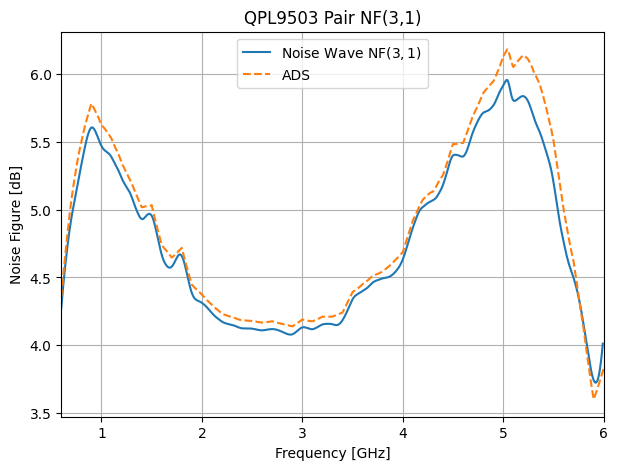

In [4]:
class dual_amp(rfn.Network):
    u1 = single_amp()
    u2 = single_amp()
    sp = wilk()

    nodes = [
        (sp|1, "P1"),
        (sp|2, u1|1),
        (sp|3, u2|1),
        (u1|2, "P2"),
        (u2|2, "P3"),
    ]

amp_dual_n = dual_amp()

ax = amp_dual_n.plot(frequency, 31, fmt='nf', label='Noise Wave')
ads_nf = np.genfromtxt(DATA_DIR / 'ads_wilk.csv', delimiter=",")
ax.plot(ads_nf[:,0], ads_nf[:, 1], '--', label='ADS')
ax.legend(loc='upper center')
ax.set_title('QPL9503 Pair NF(3,1)')

## Non-isolated Combiner Network

![image](data/img/ads_sch_noniso_pair.png)

Text(0.5, 1.0, 'QPL9503 Non-Iso Pair NF(2,1)')

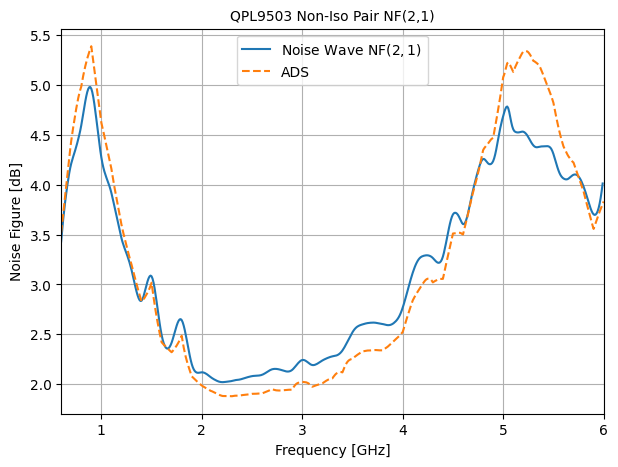

In [5]:

class dual_amp_noniso(rfn.Network):
    u1 = single_amp()
    u2 = single_amp()
    sp = splitter()

    nodes = [
        (sp|1, "P1"),
        (sp|2, u1|1),
        (sp|3, u2|1),
        (u1|2, "P2"),
        (u2|2, "P3"),
    ]

amp_dual_noniso = dual_amp_noniso()

ads_nf = np.genfromtxt(DATA_DIR / 'ads_noniso.csv', delimiter=",")
ax = amp_dual_noniso.plot(frequency, 21, fmt='nf', label='Noise Wave')
ax.plot(ads_nf[:,0], ads_nf[:, 1], '--', label='ADS')
ax.legend(loc='upper center')
ax.set_title('QPL9503 Non-Iso Pair NF(2,1)', fontsize='medium')

## Non-isolated Unbalanced Pair

This network introduces feedback through the non-isolated pair to stress test the noise wave analysis routine.

![image](data/img/ads_noniso_ubl.png)

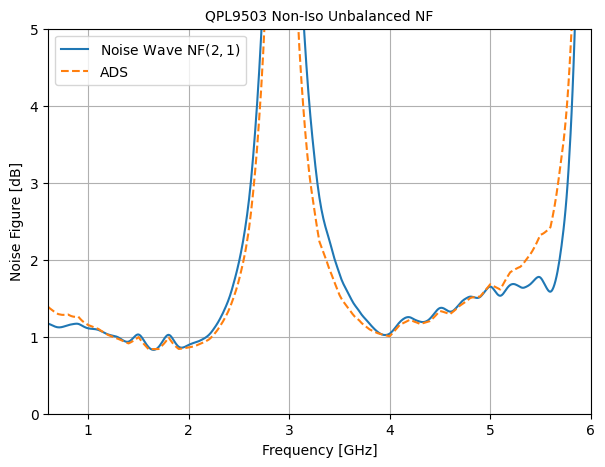

In [6]:
class dual_amp_thru(rfn.Network):
    u1 = single_amp()
    sp1 = splitter()
    sp2 = splitter()

    cascades = [
        (sp1|2, u1, sp2|2),
    ]

    nodes = [
        (sp1|3, sp2|3),
        (sp1|1, "P1"),
        (sp2|1, "P2"),
    ]

amp_dual_thru = dual_amp_thru()

ads_nf = np.genfromtxt(DATA_DIR / 'ads_noniso_unb.csv', delimiter=",")
ax = amp_dual_thru.plot(frequency, 21, fmt='nf', label='Noise Wave')
ax.plot(ads_nf[:,0], ads_nf[:, 1], '--', label='ADS')
ax.legend()
ax.set_title('QPL9503 Non-Iso Unbalanced NF', fontsize="medium")
ax.set_ylim([0, 5]);